### Visualise dynamics across global simulations - SP mode Atkin new vertical scaling scheme

Interactive maps adapted from Charlie Koven here: 

https://nbviewer.org/github/ckoven/ctsm_py/blob/fates_interactive/notebooks/fates_interactive_notebook.ipynb


In [1]:
#pip install panel
#pip install holoviews
#pip install hvplot

#### Libraries

In [2]:
import xarray as xr
import cftime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import panel as pn
import holoviews as hv
import hvplot.xarray
import functions_py.fates_xarray_functions as fa
import cartopy.crs as ccrs

#### Functions

In [3]:
def decay_coeff_kn(vcmax25top):
    ans = np.exp(0.00963 * vcmax25top - 2.43)
    return ans


def clllpf_to_cn_lf_by_pft(clllpf_var, dataset, dataset2):
    """function to reshape a fates multiplexed canopy layer, leaf layer and pft-indexed variable to one indexed by canopy layer leaf layer and pft
    first argument should be an xarray DataArray that has the FATES CLLLPF dimension
    second argument should be an xarray Dataset that has the FATES CLLL dimensions
    (possibly the dataset encompassing the dataarray being transformed)
    returns an Xarray DataArray with the cnlf  (CLLL) and pft dimensions disentangled"""
    n_cnlf = len(dataset.fates_levcnlf)
    ds_out = (clllpf_var.rolling(fates_levcnlfpf=n_cnlf, center=False)
            .construct("fates_levcnlf")
            .isel(fates_levcnlfpf=slice(n_cnlf-1, None, n_cnlf))
            .rename({'fates_levcnlfpf':'fates_levpft'})
            .assign_coords({'fates_levcnlf':dataset.fates_levcnlf})
            .assign_coords({'fates_levpft':dataset.fates_levpft}))
    ds_out.attrs['long_name'] = clllpf_var.attrs['long_name']
    ds_out.attrs['units'] = clllpf_var.attrs['units']
    
    # now create a new dimension - leaf layers - and disentangle canopy layers and leaf layers
    n_levleaf = len(dataset2.fates_levleaf)
    ds_out2 = (ds_out.rolling(fates_levcnlf=n_levleaf, center=False)
               .construct("fates_levleaf")
               .isel(fates_levcnlf=slice(n_levleaf-1, None, n_levleaf))
               .rename({'fates_levcnlf':'fates_levcan'})
               .assign_coords({'fates_levleaf':dataset2.fates_levleaf})
               .assign_coords({'fates_levcan':dataset.fates_levcan}))
    ds_out2.attrs['long_name'] = ds_out.attrs['long_name']
    ds_out2.attrs['units'] = ds_out.attrs['units']
    
    return(ds_out2)

#### Load FATES run

In [4]:
# Ryan 
#filename = '/compyfs/need138/elm_runs/spmode_ryan.Ec63cce2-F76adbb7.2022-11-22/run/lnd/hist/spmode_ryan.Ec63cce2-F76adbb7.2022-11-22.elm.h0.fullrun.nc'

# Atkin 
filename = '/compyfs/need138/elm_runs/spmode_atkin_newvertprof.Ec63cce2-F76adbb7.2022-11-22/run/lnd/hist/spmode_atkin_newvertprof.Ec63cce2-F76adbb7.2022-11-22.elm.h0.fullrun.nc'
fin= xr.open_dataset(filename)

fin['time'] = np.arange(len(fin['time']))

nyears = int(len(fin.variables['time'])/12)
tave_start = (nyears-5)*12
tave_stop = nyears*12

pftnames = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']


#### Calculate leaf construction cost per pft

In [5]:
# Leaf construction cost depends on cumulative LAI which corresponds to the leaf layer 
# dimension in CLLLPF. Therefore calculate leaf construction cost for each leaf layer and
# subtract from NET_C_UPTAKE_CLLLPF to get the full net C uptake. 

# PFT level parameters 
vcmax25top = [50, 62, 39, 61, 41, 58, 62, 54, 54, 78, 78, 78]
slatop = [0.012, 0.005, 0.024, 0.009, 0.03, 0.03, 0.012, 0.03, 0.03, 0.03, 0.03, 0.03]
slamax = [0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.012, 0.03, 0.03, 0.03, 0.03, 0.03]
root_long = [1, 2, 1, 1.5, 1, 1, 1.5, 1, 1, 1, 1, 1]
leaf_long = [1.5, 4, 1, 1.5, 1, 1, 1.5, 1, 1, 1, 1, 1]
season_decid = [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]
stress_decid = [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]
grperc = [0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11]
l2fr = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ]

vai_top_bin_width = 0.1
vai_width_increase_factor = 1.1
nlevleaf = 37 # it is actually 36 but do 37 here to get midpoints
z = np.linspace(1,nlevleaf,nlevleaf)
dinc_vai = vai_top_bin_width * vai_width_increase_factor ** z
cumulative_lais = np.cumsum(dinc_vai)

lower = cumulative_lais[0:-1]
upper = cumulative_lais[1:]
leaf_layer_mids = (lower + upper)*0.5

# make a dataset that has a fates_levleaf dimension
data = np.arange(36)
locs = leaf_layer_mids
dataset2 = xr.DataArray(data, coords={'fates_levleaf':locs}, dims = 'fates_levleaf')

# untangle all the dimensions  - this variable is in kg C m-2 s-1 (per ground area NOT leaf area)
ds5 = fa.clllpf_to_cn_lf_by_pft(fin['FATES_NET_C_UPTAKE_CLLLPF'], fin, dataset2) 

leaf_costs = []

# This is kg C m-2 yr-1 (per unit ground area?)
for pf in range(0, len(pftnames)):
    
    pft_kn = decay_coeff_kn(vcmax25top[pf])
    nscaler_levleaf = np.exp(-pft_kn * leaf_layer_mids)  
    sla_levleaf = slatop[pf] / nscaler_levleaf
    m = [idx for idx in range(len(sla_levleaf)) if sla_levleaf[idx] > slamax[pf]]
    sla_levleaf[m] = slamax[pf]
    
    # if deciduous
    if(season_decid[pf] == 1) or (stress_decid[pf] == 1):
        # account for sla profile 
        leaf_cost = 1 / (sla_levleaf * 1000) 
        # growth respiration tax
        leaf_cost = (leaf_cost * (grperc[pf] + 1))
    
    # if evergreen    
    else : 
        leaf_cost = (1 / (sla_levleaf * 1000) * leaf_long[pf]) 
        leaf_cost = (leaf_cost * (grperc[pf] + 1)) 
    
    bfr_per_bleaf = l2fr[pf]
    leaf_cost = leaf_cost + ( 1 / (sla_levleaf * 1000) * bfr_per_bleaf / root_long[pf] )
    
    # now subtract this leaf cost from the relevant dimensions
    leaf_costs.append(leaf_cost)
    

#### Subtract leaf construction cost

In [6]:
leaf_costs = xr.DataArray(leaf_costs, dims = ['fates_levpft', 'fates_levleaf'])    

# max area of each pft in no comp
pft_frac = fin.FATES_NOCOMP_PATCHAREA_PF  # in m2 m-2


# Subtract leaf costs from net C uptake ( make net C uptake annual)
ds6 = (ds5/pft_frac * 86400 * 365) - leaf_costs

# Now in kg C m-2 yr-1

#### Average over time and remove empty canopy layers

In [7]:
# remove empty canopy layer
ds7 = ds6.isel(fates_levcan=0)
print(ds7.coords)

# mean over time
ds8 = ds7.mean(dim='time')

# sum over pfts
ds9 = ds8.sum(dim='fates_levpft')


print(ds9.max())
print(ds9.min())

Coordinates:
  * time           (time) int64 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119
  * lon            (lon) float32 0.0 5.0 10.0 15.0 ... 340.0 345.0 350.0 355.0
  * lat            (lat) float32 -90.0 -86.0 -82.0 -78.0 ... 78.0 82.0 86.0 90.0
    fates_levcan   int32 1
  * fates_levpft   (fates_levpft) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * fates_levleaf  (fates_levleaf) float64 0.1705 0.2976 0.4373 ... 31.36 34.6
<xarray.DataArray ()>
array(inf)
Coordinates:
    fates_levcan  int32 1
<xarray.DataArray ()>
array(-inf)
Coordinates:
    fates_levcan  int32 1


/share/apps/E3SM/conda_envs/base/envs/e3sm_unified_1.7.1_nompi/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


#### Plot net C uptake by leaf layer for each PFT across the globe

In [8]:
image = ds9.hvplot('lon', 'lat', cmap='coolwarm', width=600, clim=(-5,5))

stream = hv.streams.Tap(source=image, x=0, y=0)

@pn.depends(stream.param.x, stream.param.y)

def lainetc(x, y):
    return ds8.sel(lon=x, lat=y, method='nearest').hvplot('fates_levleaf', width=600)

pn.Column(image, lainetc)

Column
    [0] Row
        [0] HoloViews(DynamicMap)
        [1] Column
            [0] WidgetBox
                [0] DiscreteSlider(margin=(20, 20, 20, 20), name='fates_levleaf', options=OrderedDict([('0.1705', ...]), value=0.17050000000000004, width=250)
            [1] VSpacer()
    [1] ParamFunction(function)

''

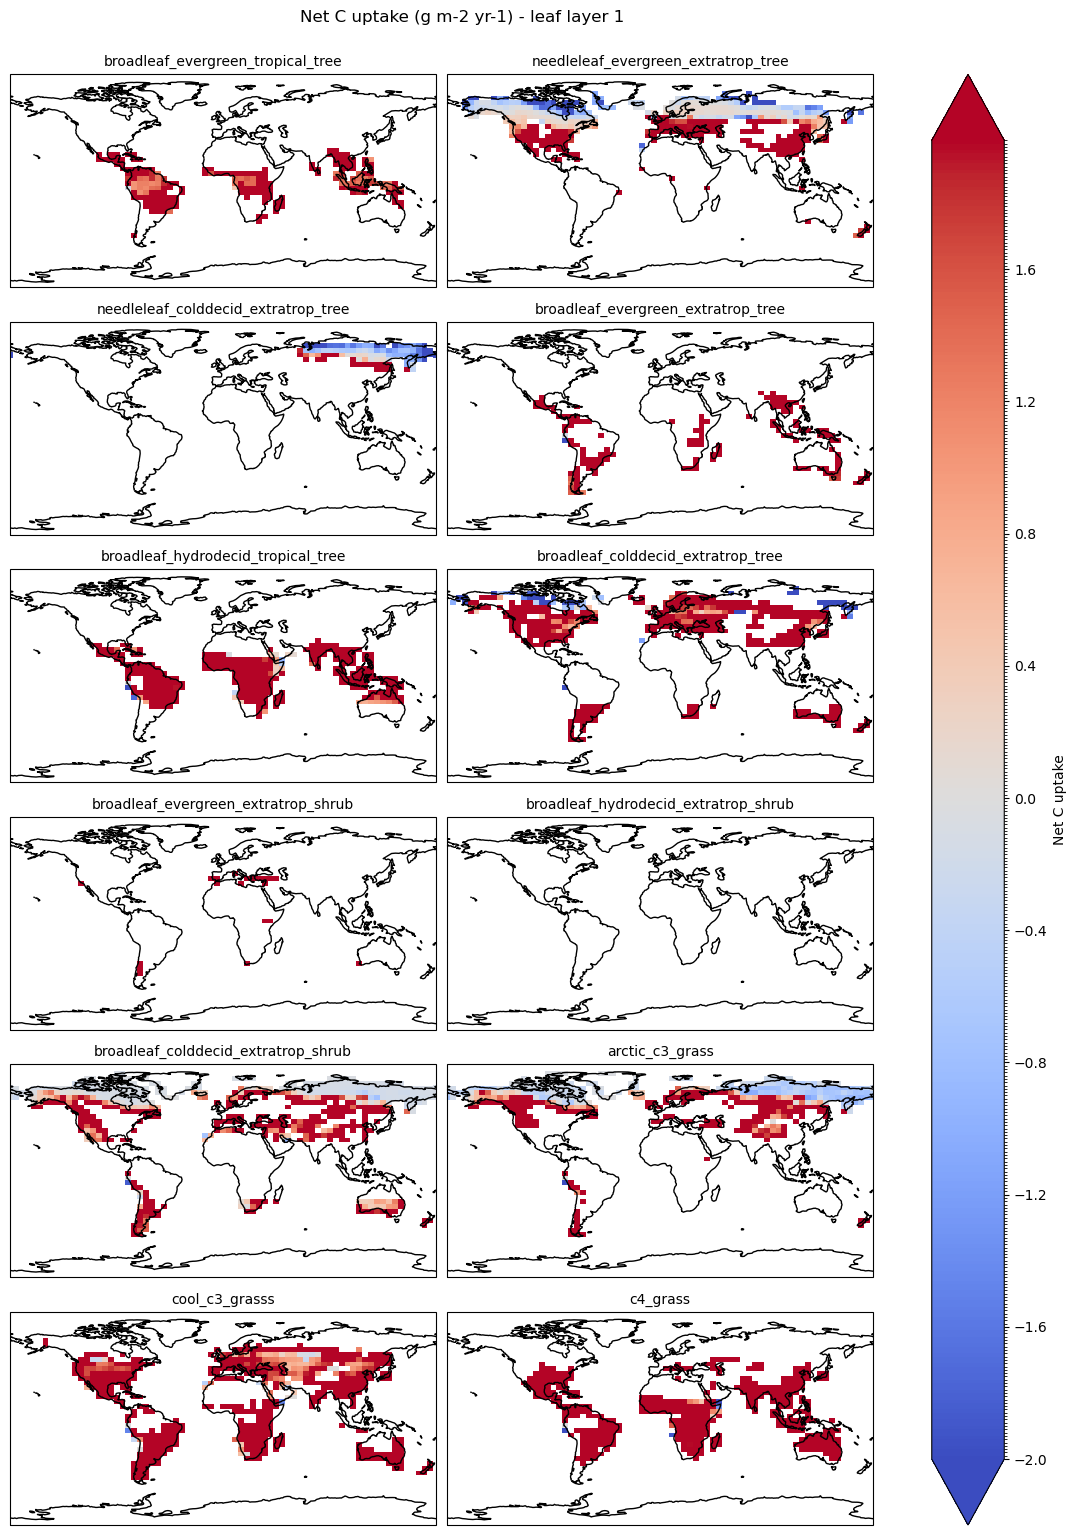

In [9]:
ds10 = ds8.isel(fates_levleaf=0)

g = ds10.plot(x="lon",y="lat",col="fates_levpft", col_wrap=2, 
           figsize=(12, 15),
      cbar_kwargs={"label": "Net C uptake"},
      subplot_kws={"projection":ccrs.PlateCarree(),"facecolor":"white"},
          levels = np.arange(-2,2,0.01), cmap='coolwarm',
            facecolor="white")

for i, ax in enumerate(g.axes.flat):
    ax.set_title(pftnames[i], fontsize=10)

[ax.coastlines() for ax in g.axes.flatten()]

# Add a big title at the top
plt.suptitle('Net C uptake (g m-2 yr-1) - leaf layer 1', y=1.02, x = 0.45)
;

''

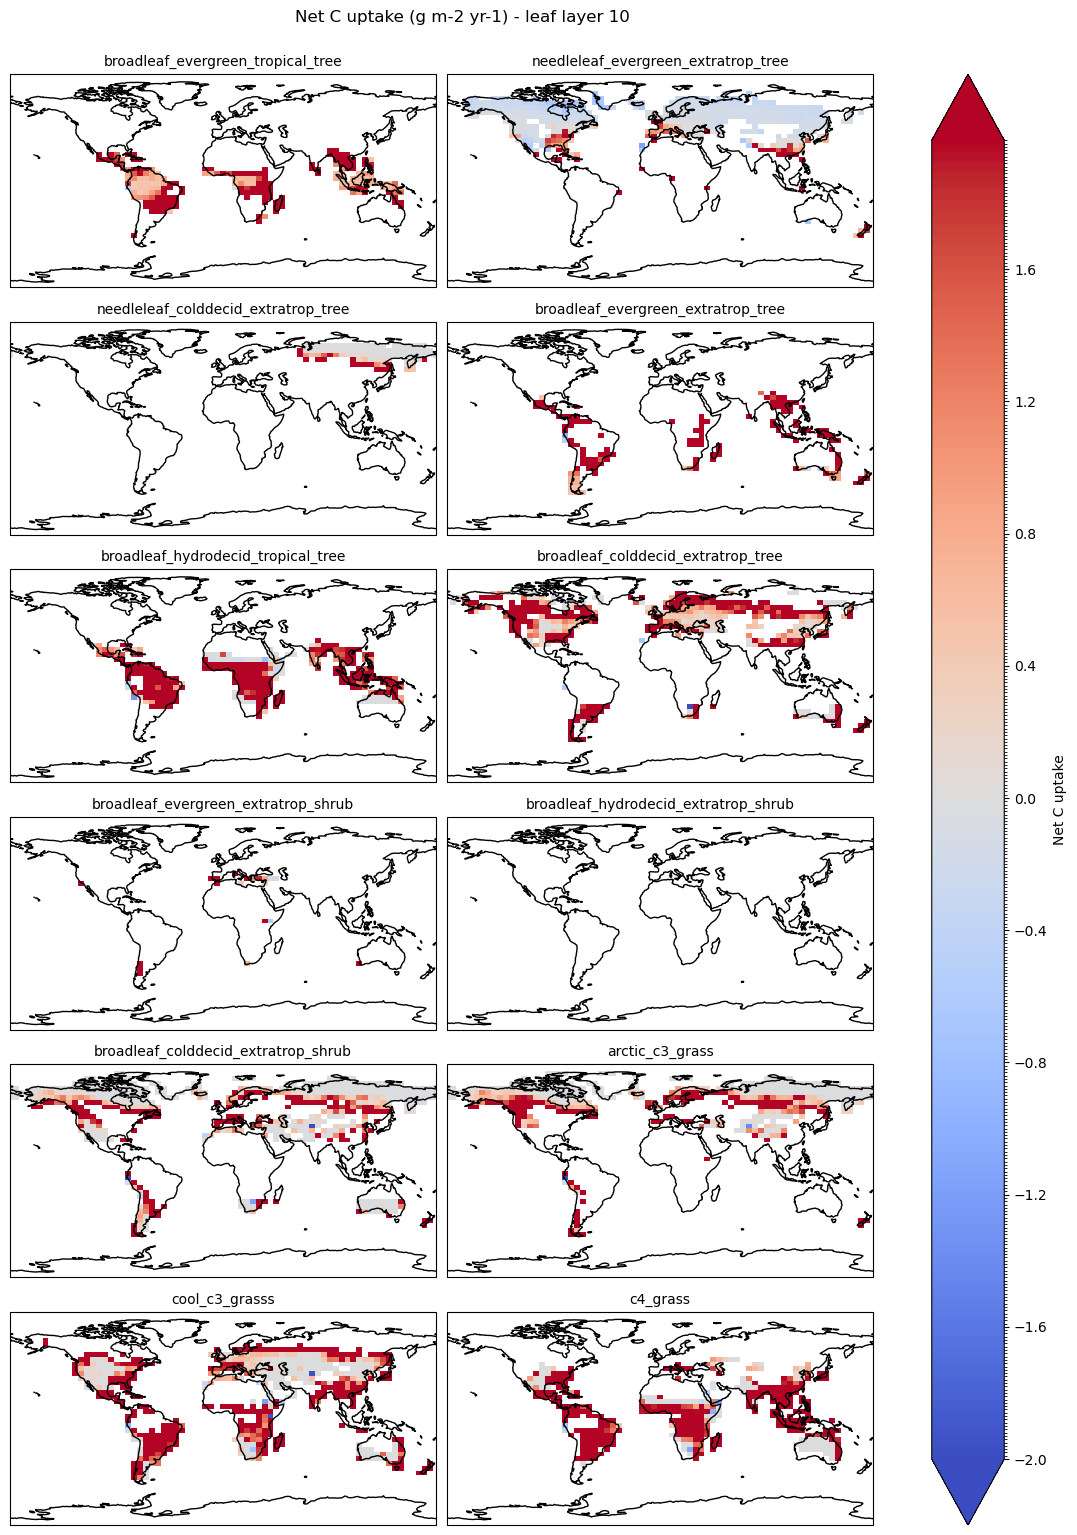

In [10]:
ds11 = ds8.isel(fates_levleaf=9)

g = ds11.plot(x="lon",y="lat",col="fates_levpft", col_wrap=2, 
           figsize=(12, 15),
      cbar_kwargs={"label": "Net C uptake"},
      subplot_kws={"projection":ccrs.PlateCarree(),"facecolor":"white"},
          levels = np.arange(-2,2,0.01), cmap='coolwarm',
            facecolor="white")

for i, ax in enumerate(g.axes.flat):
    ax.set_title(pftnames[i], fontsize=10)

[ax.coastlines() for ax in g.axes.flatten()]

# Add a big title at the top
plt.suptitle('Net C uptake (g m-2 yr-1) - leaf layer 10', y=1.02, x = 0.45)
;